In [3]:
import import_ipynb
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import time as timer

In [4]:
def OR_gate(bn, x, ylist): 
    # x: child
    # yDlist : parents
    #
    def p2table1(p):
        v = np.zeros(2)
        v[:] = [1-p,p]
        return v

    def p2table2(p):
        v = np.zeros((2,2))
        v[0,:] = [1,0]
        v[1,:] = [1-p,p]
        return v   

    
    
    bn.add(x, 2)
    #bn.cpt(bn.idFromName(x))[:] = p2table1(0.1)
    
        
    def makecpds1(bn, x,ylist):
        u = np.zeros((2,2))
        u[0,:] = [1,0]
        u[1,:] = [0,1]

        my_arc_list = ''
        my_node_list = list()
        x0 = x
        print(ylist[0])
        bn.addArc(bn.idFromName(ylist[0]),bn.idFromName(x0))
        bn.cpt(bn.idFromName(x0))[:] = u
        return  bn

    def makecpds2(bn, x,ylist):
        u = np.zeros((2,2,2))
        u[0,0,:] = [1,0]
        u[0,1,:] = [0,1]
        u[1,0,:] = [0,1]
        u[1,1,:] = [0,1]
        my_arc_list = ''
        my_node_list = list()
        x0 = x
        for i, y in enumerate(ylist[:-2]):
            z = 'Coparent'+str(y)+x     # hulp knoop, coparent van y in OR die wijst naar x
            my_node_list += [z]
            bn.add(z, 2)
            my_arc_list += x0+'<-'+y+';'
            my_arc_list += x0+'<-'+z+';'
            bn.addArc(bn.idFromName(y),bn.idFromName(x0))
            bn.addArc(bn.idFromName(z),bn.idFromName(x0))
            bn.cpt(bn.idFromName(x0))[:] = u
            x0 = z
        y = ylist[-2]    
        z = ylist[-1]
        my_arc_list += x0+'<-'+y+';'
        my_arc_list += x0+'<-'+z+';'
        bn.addArc(bn.idFromName(y),bn.idFromName(x0))
        bn.addArc(bn.idFromName(z),bn.idFromName(x0))
        bn.cpt(bn.idFromName(x0))[:] = u
        return  bn

    def makecpds(bn, x,ylist):
        if(len(ylist)>=2):
            bn = makecpds2(bn, x,ylist)
        elif(len(ylist)==1):
            print(ylist)
            bn = makecpds1(bn, x,ylist)
        return bn
    
    bn =  makecpds(bn, x, ylist)
                
    return bn

In [1]:
def create_noisy_or():
    """
    Creates a noisy_or network with diagnosis and tests. They can be filled in manually
    """
    # Create a list diagnoses
    diags = [chr(i) for i in range(ord('a'), ord('a')+3)]
    # Create an empty dictionary to store the random values
    prior = {}

    # Loop through each letter in the list and add a random value to the dictionary
    for d in diags:
        prior[d] = np.random.uniform(0, 1)
        
    steps = 3 # Replace 3 with the desired number of steps
    tests = [chr(ord('z') - i) for i in range(steps)]
    sens= {}
    for t in tests:
        sens[t] = {}
        for d in diags:
            sens[t][d] = np.random.uniform(0, 1)
    bnNOR=gum.BayesNet('noisy-OR network')
    for d in diags:
        bnNOR.add(gum.LabelizedVariable(d,d,2))
        bnNOR.cpt(d).fillWith([1-prior[d],prior[d]])
        for t in tests:
            u = np.zeros((2,2))
            u[0,:] = [1,0]
            u[1,:] = [1-sens[t][d],sens[t][d]]
            bnNOR.add(gum.LabelizedVariable(t+d,t+d,2))
            bnNOR.addArc(bnNOR.idFromName(d),bnNOR.idFromName(t+d))
            bnNOR.cpt(t+d)[:] = u
    
    for t in tests:
        bnNOR = OR_gate(bnNOR, t, [t+d for d in diags])
    return bnNOR

In [5]:
bn = create_noisy_or()
pred = create_noisy_or()
bn_real = gum.saveBN(bn, "BigNoisy.bif")
pred_real = gum.saveBN(pred, "BigNoisy_pred.bif")


(pyAgrum.BayesNet<double>@000001E6AF2AD3C0) BN{nodes: 18, arcs: 21, domainSize: 262144, dim: 45, mem: 720o}

In [6]:
def generate_truth_table(num_inputs):
    """
    Generates a combination of 0's and 1's depending on the number of inputs.
    An input of 4 would result in an array [00, 10, 01, 11].
    """
    table = []
    for i in range(2**num_inputs):
        row = []
        for j in range(num_inputs):
            row.append((i // 2**j) % 2)
        table.append(row)
    return table

def get_theta(bn):
    """Gets all the theta's from a bayesian network

    Args:
        bn (_type_): a bayesian network

    Returns:
        theta: all theta's from a bayesian network
    """
    theta = []
    for var in sorted(bn.names()):
        parents = sorted(bn.parents(var))
        if len(parents) == 0:
            dic = {}
            dic[var] = 1
            theta.append(dic)
        else:
            elems = generate_truth_table(len(parents))
            for combination in elems:
                dic = {}
                dic[var] = 1
                for value in range(len(combination)):
                    parent = list(bn.parents(var))[value]
                    name = bn.variable(parent).name()
                    dic[name] = combination[value]
                theta.append(dic)
    return theta

def get_parameters(bn):
    """
    Gets the parameters out of a Bayesian Network and returns them as an array
    """
    parameters = []
    names = sorted(bn.names())
    for name in names:
        prob = bn.cpt(name).toarray().flatten()
        if len(prob) == 2:
            parameters.append(prob[1])
        else:
            for i in range(len(prob)):
                if i % 2 != 0:
                    parameters.append(prob[i])
    parameters = np.array(parameters)
    return parameters

def calculate_posterior(bn, posterior, evidence = {}):
    """
    Calculates the posterior probability of a variable in a Bayesian Network. The default is without evidence, 
    but can be added if this is needed
    """
    ie = gum.LazyPropagation(bn)
    ie.setEvidence(evidence)
    post = ie.posterior(posterior)
    prob = np.array([post[0], post[1]])
    return prob[1]   


def set_cpt(bn, probabilities):
    """
    Given a Bayesian Network and an array of probabilities, this function will update the cpt of the Bayesian Network based 
    on the array. 
    Variables will be traversed alphabetically
    """
    variables = sorted(bn.names())
    current = 0
    for i in range(len(variables)):
        node = variables[i]
        parents = bn.parents(node)
        if not parents:
            bn.cpt(node).fillWith([1-probabilities[current], probabilities[current]])
            current += 1
        else:
            length = len(parents)
            elements = pow(2,length)
            probs = []
            for j in range(current, current+elements):                    
                if not(probabilities[j] == 0 or probabilities[j] == 1):
                    probs.append(1-probabilities[j])
                    probs.append(probabilities[j])
                current += 1
            bn.cpt(node).fillWith(np.array(probs))
    return bn  

In [7]:
def get_parameters_noisy(bn):
    """Gets all parameters from a bayesian network

    Args:
        bn (_type_): a bayesian network

    Returns:
        parameters: an array of probabilities
    """
    param = []
    root = []
    for var in sorted(bn.names()):
        parent = sorted(bn.parents(var))
        if len(parent) == 0:
            root.append(var)
            
    for var in sorted(bn.names()):
        parent = sorted(bn.parents(var))
        
        prob = bn.cpt(var).toarray().flatten()
        if len(prob) == 2:
            param.append(prob[1])
        else:
            name = bn.variable(parent[0]).name()
            if name in root:
                
                param.append(prob[3])
                
    parameters = np.array(param)
    return parameters

def get_theta_noisy(bn):
    """Gets all theta's from a bayesian network

    Args:
        bn (_type_): a bayesian network

    Returns:
        theta: all parameters of a bayesian network
    """
    theta = []
    root = []
    for var in sorted(bn.names()):
        parent = sorted(bn.parents(var))
        if len(parent) == 0:
            dic = {}
            dic[var] = 1
            theta.append(dic)
            root.append(var)
    for var in sorted(bn.names()):
        parent = sorted(bn.parents(var))
        
        if len(parent) > 0:
            name = bn.variable(parent[0]).name()
            if name in root:
                dic = {}
                dic[var] = 1
                dic[name] = 1
                theta.append(dic)
    return theta

def set_cpt_noisy(bn, probabilities):
    """
    Given a Bayesian Network and an array of probabilities, this function will update the cpt of the noisy-or Bayesian Network based 
    on the array. 
    Variables will be traversed alphabetically
    """
    root = []
    for var in sorted(bn.names()):
        if len(bn.parents(var)) == 0:
            root.append(var)
            
    
    variables = sorted(bn.names())
    current = 0
    for i in range(len(variables)):
        node = variables[i]
        parents = sorted(bn.parents(node))
        if not parents:
            bn.cpt(node).fillWith([1-probabilities[current], probabilities[current]])
            current += 1
        else:
            name = bn.variable(parents[0]).name()
            if name in root:
                bn.cpt(node)[{name:1}] = [1-probabilities[current], probabilities[current]]
                current += 1
    return bn  

In [8]:
print(len(get_theta_noisy(bn)))

12


In [9]:
def check(I, clammed):
    """
    Checks if the value at the clammed spot and the instantiation of the complete joint probability are the same for all variables
    """
    for x in clammed:
        if I[x] != clammed[x]:
                return False
    return True

def remove_first_key(my_dict):
    """
    Removes the first key and value pair of a dictionary and returns this first key and a new dict without this first one
    """
    keys = list(my_dict.keys())
    
    first = keys.pop(0)
    
    new_dict = {key: my_dict[key] for key in keys}
    
    return first, new_dict

def add_lists(list1, list2):
    """
    Adds two lists together element-wise.
    Assumes both lists are of equal length.
    """
    return [x + y for x, y in zip(list1, list2)]

def tuple_to_dict(t):
    """Converts a tuple of alternating key-value pairs to a dictionary."""
    d = {}
    for i in range(0, len(t), 2):
        key = t[i]
        value = t[i+1]
        d[key] = value
    return d
def dict_to_tuple(d):
    """Converts a dictionary to a tuple of alternating key-value pairs."""
    t = tuple(d.items())
    return sum(t, ())       

In [10]:
def generate_reversed(bn, nr):
    itr = 0
    names = list(bn.names())
    id = bn.ids(list(names))
    params = []
    while itr < nr:
        
        nrs = random.choices(id, k=2)
        random_number = random.randint(0, 1)
        if nrs[1] in bn.descendants(nrs[0]):
            name1 = bn.variable(nrs[0]).name()
            name2 = bn.variable(nrs[1]).name()
            if (name1,1,name2 , random_number) not in params:
                params.append((name1,1,name2 , random_number))
                itr += 1
        elif nrs[0] in bn.descendants(nrs[1]):
            name1 = bn.variable(nrs[0]).name()
            name2 = bn.variable(nrs[1]).name()
            if (name2,1,name1 , random_number) not in params:
                params.append((name2,1,name1 , random_number))
                itr += 1
    return params

def convert(bn, c):
    vals = {}
    for a, v, b, v1 in c:
        prob = calculate_posterior(bn, a, {b:v1}) 
        vals[(a, v, b, v1)] = prob  
    return vals

def generate_reversed_noisy(bn, nr):
    itr = 0
    names = list(bn.names())
    id = bn.ids(list(names))
    params = []
    while itr < nr:
        
        nrs = random.choices(id, k=2)
        random_number = random.randint(0, 1)
        if nrs[1] in bn.descendants(nrs[0]) and len(bn.ancestors(nrs[0])) == 0 and len(bn.descendants(nrs[1])) == 0:
            name1 = bn.variable(nrs[0]).name()
            name2 = bn.variable(nrs[1]).name()
            if (name1,1,name2 , random_number) not in params:
                params.append((name1,1,name2 , random_number))
                itr += 1
        elif nrs[0] in bn.descendants(nrs[1]) and len(bn.ancestors(nrs[1])) == 0 and len(bn.descendants(nrs[0])) == 0:
            name1 = bn.variable(nrs[0]).name()
            name2 = bn.variable(nrs[1]).name()
            if (name2,1,name1 , random_number) not in params:
                params.append((name2,1,name1 , random_number))
                itr += 1
    return params

In [11]:
def gradient(bn, joint, theta):
    """
    Calculates the gradient of a probability with respect to theta
    """
    first2, new = remove_first_key(theta)
    val = joint[first2]
    if val == 0:
        for var in new:
            if not(theta[var] == joint[var]):
                return 0
        return -1
    else:
        for var in new:
            if not(theta[var] == joint[var]):
                return 0
        return 1
    
    
def gamma(bn, joint, theta): 
    """
    Calculates the gamma part of the article
    """
    # length = len(list(theta.keys()))
    # p = 0
    var = list(theta.keys())
    first2, new = remove_first_key(theta)
    
    prob = 0
    t = True
    # print("First2",bn.cpt(first2))
    # print("Theta", theta)
    # print("Joint", joint)
    for var in theta:
        if not(theta[var] == joint[var]):
            t = False
    if t:
        prob = bn.cpt(first2)[new][1]
    else:
        prob = bn.cpt(first2)[new][0]
    # print("Prob div", prob)
    # print("Prob1",prob1)
    # print("Theta", theta)
    # print("X", x)
    first = np.divide(1,prob)
    # print("First", first)
    # print("First gamma", first)
    # print("First", first)
    second = gradient(bn, joint, theta)
    # print("Second", second)
    # print("Gradient -1,1,0", second)
    # print("Second", second)
    # second = 0
    total = first * second
    # print("Total gamma", total)
    return total


def gradient_cpt(bn, clammed, theta):
    """
    Calculates the gradient of the cpt according to the article
    bn = bayesian network
    clammed = dictionary of clammed variables and their values
    """
    # print("Clammed", clammed)
    # print("Theta", theta)
    x = set()
    c = list(clammed.keys())
    t = list(theta.keys())
    if len(c) == 1:
        ancestors = bn.ancestors(bn.idFromName(c[0]))
        if bn.idFromName(t[0]) in ancestors or t[0] == c[0]:
            x.add(c[0])
            if c[0] in t:
                t.remove(c[0])
            for t1 in t:
                if t1 not in x:
                    x.add(t1)
            # print("X", x)
            lp = gum.LazyPropagation(bn)
            lp.addJointTarget(x)
            joint_prob = lp.jointPosterior(x)
            values = generate_truth_table(len(t))
            total = 0
            # print("Values", values)
            # print("Length", len(values))
            # print("Length",len(values))
            if len(values) > 0:
                for i in range(len(values)):
                    joints = {}
                    joints[c[0]] = clammed[c[0]]
                    # print("Values2", values[i])
                    for k in range(len(values[i])):
                        joints[t[k]] = values[i][k]
                    # print("Joints", joints)
                    prob = joint_prob[joints]
                    # print("Joint_prob", joint_prob)
                    # print("Joints", joints)
                    # print("PRob", prob)
                    # print("Prob", prob)
                    # print("Joints", joints)
                    grad = gamma(bn, joints, theta)
                    # print("Grad", grad)
                    total += prob * grad
                # print("Total cpt", total)
                return total
            else:
                # print("HALLO")
                joints = {}
                joints[c[0]] = clammed[c[0]]
                # print("Joints same theta", joints)
                prob = joint_prob[joints]
                grad = gamma(bn, joints, theta)
        else:
            return 0
    else:
        ancestors = bn.ancestors(bn.idFromName(c[1]))
        if bn.idFromName(t[0]) in ancestors or t[0] == c[1]:
            x.add(c[0])
            x.add(c[1])
            if c[0] in t:
                t.remove(c[0])
            if c[1] in t:
                t.remove(c[1])
            for t1 in t:
                if t1 not in x:
                    x.add(t1)
            # print("X", x)
            lp = gum.LazyPropagation(bn)
            lp.addJointTarget(x)
            joint_prob = lp.jointPosterior(x)
            values = generate_truth_table(len(t))
            total = 0
            # print("Values", values)
            # print("Length", len(values))
            if len(values) > 1:
                for i in range(len(values)):
                    joints = {}
                    joints[c[0]] = clammed[c[0]]
                    joints[c[1]] = clammed[c[1]]
                    # print("Values2", values[i])
                    for k in range(len(values[i])):
                        joints[t[k]] = values[i][k]
                    # print("Joints", joints)
                    prob = joint_prob[joints]
                    # print("Joint_prob", joint_prob)
                    # print("Joints", joints)
                    # print("PRob", prob)
                    # print("Prob", prob)
                    grad = gamma(bn, joints, theta)
                    # print("Grad", grad)
                    total += prob * grad
                # print("Total", total)
                # print("Total cpt", total)
                return total
            else:
                # print("HALLO!")
                joints = {}
                joints[c[0]] = clammed[c[0]]
                joints[c[1]] = clammed[c[1]]
                prob = joint_prob[joints]
                grad = gamma(bn, joints, theta)
                return grad * prob
        else:
            return 0
    

def gradient_probability(bn, probabilities, theta):
    """
    Calculates the gradient of the probabilities with respect to theta according to the article
    """
    # print("Theta", theta)
    keys = list(probabilities.keys())
    first = keys[0]
    second = keys[1]
    ie = gum.LazyPropagation(bn)
    post = ie.posterior(second)
    c = 0
    x = 0
    if probabilities[second] == 0:
        c = post[0]
        
    else:
        c = post[1]
        
    if probabilities[first] == 1:
        x = calculate_posterior(bn, first, remove_first_key(probabilities)[1])
    else: 
        x = 1 - calculate_posterior(bn, first, remove_first_key(probabilities)[1])
    grad1 = gradient_cpt(bn, probabilities, theta)
    # print("Grad prob 1", grad1)
    # print("Grad1", grad1)
    # print("Grad prob 1", grad1)
    grad2 = gradient_cpt(bn, remove_first_key(probabilities)[1], theta)
    # print("Grad prob 2", grad2)
    # print("Grad2", grad2)
    # print("Grad prob 2", grad2)
    # print("C", c)
    # print("x", x)
    # grad1 = 0
    # grad2 = 0
    total = np.divide(1, c) * (grad1 - x * grad2)
    # print("Total", total)

    return total

def gradient_loss(bn, probabilities, y_true, y_pred, theta):
    """
    Calculates the gradient of the loss with respect to theta, according to the article
    """

    loss = -2 * y_true[probabilities] + 2 * y_pred[probabilities]
    # true = y_true[probabilities]
    # pred = y_pred[probabilities]
    # loss = -1 * np.divide(true, pred) + np.divide(1-true, 1-pred)
    probabilities = tuple_to_dict(probabilities)
    grad = gradient_probability(bn, probabilities, theta)
    # print("Grad prob", grad)
    # print("Total gradient", grad)
    total = loss * grad
    return total

In [12]:
def sse(dict1, dict2):
    """
    Computes the sum of squared errors between two arrays.

    Args:
        arr1 (numpy array): The first array.
        arr2 (numpy array): The second array.

    Returns:
        float: The sum of squared errors between arr1 and arr2.
    """
    arr1 = np.array(list(dict1.values()))
    arr2 = np.array(list(dict2.values()))
    sse = np.sum((arr1 - arr2) ** 2)
    return sse

def kl_divergence(p, q):
    """
    Calculate the Kullback-Leibler divergence between two arrays.
    
    Parameters:
        p (numpy.ndarray): Probability distribution array.
        q (numpy.ndarray): Probability distribution array.
        
    Returns:
        float: Kullback-Leibler divergence value.
    """
    a = np.array(list(p.values()))
    b = np.array(list(q.values()))
    return np.sum(np.where(a != 0, a * np.log1p(a / b), 0))


In [13]:
def gradient_descent(pred, y_true, y_pred, rev):
    """
    Performs gradient descent on a given prediction network
    """
    theta_pred = get_parameters(pred)
    theta = get_theta(pred)

    start_time = timer.time()
    losses = []
    j=0
    iterations = 10000
    previous = []
    lr = 0.08
    for j in range(iterations):
        s = np.zeros(len(theta))
        for i in y_true:
            grads = []
            for x in theta:
                grad = gradient_loss(pred, i, y_true, y_pred, x)
                grads.append(grad)
            s = add_lists(s,grads)
        new_list = [x * lr for x in s]
        new_list = np.divide(new_list, len(y_true))
        theta_pred = theta_pred - new_list
        for i in range(len(theta_pred)):
            if theta_pred[i] > 1:
                theta_pred[i] = 0.999999999999
            elif theta_pred[i] < 0:
                theta_pred[i] = 0.000000000001
        loss = sse(y_true, y_pred)
        losses.append(loss)
        pred = set_cpt(pred, theta_pred)
        y_pred = convert(pred, rev)
        values = list(y_pred.values())
        values2 = list(y_true.values())
        j += 1
        if j % 100 == 0:
            print(j)
            print(theta_pred)
            print(y_pred )
        terminated = True
        for i in range(len(y_pred)):
            if not(values[i] < values2[i] + 0.01 and values[i] > values2[i] - 0.01):
                terminated = False
        if np.array_equal(previous, y_pred) or np.array_equal(previous, y_true) or terminated:
            print("Nr of iterations:", j)
            end_time = timer.time()
            t = end_time - start_time
            return theta_pred, y_pred, j, t, losses
        previous = y_pred
    return theta_pred, y_pred, j, start_time, losses

In [14]:
def gradient_descent_noisy(pred, y_true, y_pred, rev):
    """
    Performs gradient descent on a given prediction network
    """
    # theta_pred = get_parameters(pred)
    # theta_pred = np.array([theta_pred[0], theta_pred[1],theta_pred[7],theta_pred[9]])
    theta_pred = get_parameters_noisy(pred)
    theta = get_theta_noisy(pred)
    start_time = timer.time()
    losses = []
    j=0
    iterations = 5
    previous = []
    lr = 0.08
    for j in range(iterations):
        s = np.zeros(len(theta))
        print("Test1")
        for i in y_true:
            print("Test2")
            grads = []
            for x in theta:
                # print(x)
                grad = gradient_loss(pred, i, y_true, y_pred, x)
                grads.append(grad)
            s = add_lists(s,grads)
        print("Test3")
        new_list = [x * lr for x in s]
        new_list = np.divide(new_list, len(y_true))
        theta_pred = theta_pred - new_list
        print("Test4")
        for i in range(len(theta_pred)):
            if theta_pred[i] > 1:
                theta_pred[i] = 0.999999999999
            elif theta_pred[i] < 0:
                theta_pred[i] = 0.000000000001
        loss = sse(y_pred, y_true)
        # loss = kl_divergence(y_true, y_pred)
        avg = np.divide(loss,len(y_true))
        losses.append(avg)
        print("Test5")
        pred = set_cpt_noisy(pred, theta_pred)
        y_pred = convert(pred, rev)
        print("Test6")
        values = list(y_pred.values())
        values2 = list(y_true.values())
        j += 1
        print(y_pred)
        if j % 100 == 0:
            print(j)
            print(theta_pred)
            print(y_pred )
            print(avg)
        # print(j)
        terminated = True
        for i in range(len(y_pred)):
            if not(values[i] < values2[i] + 0.01 and values[i] > values2[i] - 0.01):
                terminated = False
        print("Test7")
        if np.array_equal(previous, y_pred) or np.array_equal(previous, y_true) or terminated:
            print("Nr of iterations:", j)
            end_time = timer.time()
            t = end_time - start_time
            return theta_pred, y_pred, j, t, losses
        previous = y_pred
    return theta_pred, y_pred, j, start_time, losses

In [15]:
bn = create_noisy_or()
pred = create_noisy_or()
bn_real = gum.saveBN(bn, "f.bif")
pred_real = gum.saveBN(pred, "f_pred.bif")
bn

(pyAgrum.BayesNet<double>@0000020ABF4CB4F0) BN{nodes: 32, arcs: 40, domainSize: 10^9.63296, dim: 84, mem: 1Ko 320o}

In [16]:
r = generate_reversed_noisy(bn, 32)
r

[('c', 1, 'w', 0),
 ('b', 1, 'w', 0),
 ('c', 1, 'w', 1),
 ('a', 1, 'w', 0),
 ('c', 1, 'y', 0),
 ('a', 1, 'y', 0),
 ('d', 1, 'y', 0),
 ('a', 1, 'z', 0),
 ('b', 1, 'z', 1),
 ('b', 1, 'y', 1),
 ('d', 1, 'w', 0),
 ('c', 1, 'z', 1),
 ('a', 1, 'x', 0),
 ('c', 1, 'x', 0),
 ('b', 1, 'x', 0),
 ('d', 1, 'z', 0),
 ('d', 1, 'x', 0),
 ('c', 1, 'y', 1),
 ('b', 1, 'z', 0),
 ('d', 1, 'z', 1),
 ('a', 1, 'x', 1),
 ('d', 1, 'w', 1),
 ('d', 1, 'y', 1),
 ('a', 1, 'w', 1),
 ('b', 1, 'x', 1),
 ('c', 1, 'x', 1),
 ('c', 1, 'z', 0),
 ('a', 1, 'z', 1),
 ('d', 1, 'x', 1),
 ('b', 1, 'y', 0),
 ('a', 1, 'y', 1),
 ('b', 1, 'w', 1)]

In [17]:
def run_algorithm(bn,pred, rev):
    """
    Runs the complete algorithm. Only a run of the initialization of the Bayesian Networks is needed before this
    """
    true = convert(bn, rev)
    pred2 = convert(pred,rev)
    t, y, j, tim, loss = gradient_descent_noisy(pred, true, pred2, rev)
    return t, y, j, tim, loss
bn = gum.loadBN("f.bif")
pred = gum.loadBN("f_pred.bif")
true = convert(bn, r[:1])
pred2 = convert(pred, r[:1])
print(true)
print(pred2)
# t, y, j, tim, loss = run_algorithm(bn,pred, r[:1])
# print(t, y, j)
# print(tim, "seconds")
# distance = gum.ExactBNdistance(bn, pred)
# kl = distance.compute()['klPQ']

{('c', 1, 'w', 0): 0.7312206915821767}
{('c', 1, 'w', 0): 0.12405008474388385}


In [18]:
t, y, j, tim, loss = run_algorithm(bn,pred, r[:1])
print(t, y, j)
print(tim, "seconds")
distance = gum.ExactBNdistance(bn, pred)
kl = distance.compute()['klPQ']

Test1
Test2
Test3
Test4
Test5
Test6
{('c', 1, 'w', 0): 0.16346054084638556}
Test7
Test1
Test2
Test3
Test4
Test5
Test6
{('c', 1, 'w', 0): 0.21262220129454387}
Test7
Test1
Test2
Test3
Test4
Test5
Test6
{('c', 1, 'w', 0): 0.2711524494132594}
Test7
Test1
Test2
Test3
Test4
Test5
Test6
{('c', 1, 'w', 0): 0.3366488028056976}
Test7
Test1
Test2


In [ ]:
bn = gum.loadBN("BigNoisy.bif")
pred = gum.loadBN("BigNoisy_pred.bif")
true = convert(bn, r[:2])
pred2 = convert(pred, r[:2])
print(true)
print(pred2)
t1, y1, j1, tim1, loss1 = run_algorithm(bn,pred, r[:2])
print(t1, y1, j1)
print(tim1, "seconds")
distance = gum.ExactBNdistance(bn, pred)
kl1 = distance.compute()['klPQ']

{('b', 1, 'z', 1): 0.20833098784891949, ('c', 1, 'y', 1): 0.7932140133293798}
{('b', 1, 'z', 1): 0.8562429575411082, ('c', 1, 'y', 1): 0.17778812455443274}
Nr of iterations: 39
[0.13736599 0.05958884 0.56634614 0.303642   0.61612302 0.244681
 0.87775202 0.94460596 0.36350079 0.49934662 0.91904545 0.30372877] {('b', 1, 'z', 1): 0.2061239369248782, ('c', 1, 'y', 1): 0.7836691933702075} 39
10.817717790603638 seconds


In [ ]:
bn = gum.loadBN("BigNoisy.bif")
pred = gum.loadBN("BigNoisy_pred.bif")
true = convert(bn, r[:3])
pred2 = convert(pred, r[:3])
print(true)
print(pred2)
t2, y2, j2, tim2, loss2 = run_algorithm(bn,pred, r[:3])
print(t2, y2, j2)
print(tim2, "seconds")
distance = gum.ExactBNdistance(bn, pred)
kl2 = distance.compute()['klPQ']

{('b', 1, 'z', 1): 0.20833098784891949, ('c', 1, 'y', 1): 0.7932140133293798, ('c', 1, 'x', 0): 0.6925012329164761}
{('b', 1, 'z', 1): 0.8562429575411084, ('c', 1, 'y', 1): 0.17778812455443274, ('c', 1, 'x', 0): 0.108940000263199}
100
[0.23901534 0.08264643 0.71178593 0.303642   0.61612302 0.14581697
 0.90170128 0.95297382 0.29165495 0.49577882 0.91676531 0.319775  ]
{('b', 1, 'z', 1): 0.21029777233377156, ('c', 1, 'y', 1): 0.8129719871826784, ('c', 1, 'x', 0): 0.6784077129889405}
0.0002001134679765021
200
[0.26089554 0.08466178 0.71401645 0.303642   0.61612302 0.13132284
 0.90735382 0.95456546 0.27384358 0.49649207 0.91587976 0.32208767]
{('b', 1, 'z', 1): 0.20929976816431572, ('c', 1, 'y', 1): 0.8040818394931949, ('c', 1, 'x', 0): 0.684426141984901}
6.210198998543179e-05
Nr of iterations: 215
[0.26307853 0.08486459 0.71423807 0.303642   0.61612302 0.12977695
 0.90794399 0.95472386 0.27195959 0.49656478 0.9157927  0.32231165] {('b', 1, 'z', 1): 0.20921131405459611, ('c', 1, 'y', 1): 0

In [ ]:
bn = gum.loadBN("BigNoisy.bif")
pred = gum.loadBN("BigNoisy_pred.bif")
true = convert(bn, r[:4])
pred2 = convert(pred, r[:4])
print(true)
print(pred2)
t3, y3, j3, tim3, loss3 = run_algorithm(bn,pred, r[:4])
print(t3, y3, j3)
print(tim3, "seconds")
distance = gum.ExactBNdistance(bn, pred)
kl3 = distance.compute()['klPQ']

{('b', 1, 'z', 1): 0.20833098784891949, ('c', 1, 'y', 1): 0.7932140133293798, ('c', 1, 'x', 0): 0.6925012329164761, ('b', 1, 'z', 0): 0.13643242120687493}
{('b', 1, 'z', 1): 0.8562429575411084, ('c', 1, 'y', 1): 0.17778812455443274, ('c', 1, 'x', 0): 0.108940000263199, ('b', 1, 'z', 0): 0.025973207175205758}
100
[0.23274406 0.09161578 0.71236033 0.303642   0.61612302 0.15147057
 0.89910759 0.9522479  0.29961926 0.49768882 0.85363889 0.32802102]
{('b', 1, 'z', 1): 0.2198308812752954, ('c', 1, 'y', 1): 0.8148609200165142, ('c', 1, 'x', 0): 0.6775695597752628, ('b', 1, 'z', 0): 0.014546631977408549}
0.003926181092527847
200
[0.25894477 0.10206646 0.71640732 0.303642   0.61612302 0.14027937
 0.90366481 0.95378143 0.28514344 0.50234907 0.79819039 0.34357865]
{('b', 1, 'z', 1): 0.22271487997697642, ('c', 1, 'y', 1): 0.80545751925842, ('c', 1, 'x', 0): 0.6847228586442504, ('b', 1, 'z', 0): 0.022424916428007625}
0.003359165570887405
300
[0.27777657 0.1129927  0.71937491 0.303642   0.61612302 0

In [ ]:
bn = gum.loadBN("BigNoisy.bif")
pred = gum.loadBN("BigNoisy_pred.bif")
true = convert(bn, r[:5])
pred2 = convert(pred, r[:5])
print(true)
print(pred2)
t4, y4, j4, tim4, loss4 = run_algorithm(bn,pred, r[:5])
print(t4, y4, j4)
print(tim4, "seconds")
distance = gum.ExactBNdistance(bn, pred)
kl4 = distance.compute()['klPQ']

{('b', 1, 'z', 1): 0.20833098784891954, ('c', 1, 'y', 1): 0.7932140133293799, ('c', 1, 'x', 0): 0.6925012329164763, ('b', 1, 'z', 0): 0.13643242120687493, ('b', 1, 'y', 0): 0.1604406762633464}
{('b', 1, 'z', 1): 0.8562429575411082, ('c', 1, 'y', 1): 0.1777881245544327, ('c', 1, 'x', 0): 0.108940000263199, ('b', 1, 'z', 0): 0.025973207175205747, ('b', 1, 'y', 0): 0.021908272018348263}
100
[0.23004799 0.09611057 0.71151712 0.303642   0.61612302 0.15511694
 0.89769365 0.88766139 0.30410524 0.49909037 0.85935833 0.33335044]
{('b', 1, 'z', 1): 0.22858062795295722, ('c', 1, 'y', 1): 0.8165705984231304, ('c', 1, 'x', 0): 0.6757277214938111, ('b', 1, 'z', 0): 0.014734089614635005, ('b', 1, 'y', 0): 0.011803966843663612}
0.007636928306550867
200
[0.26017018 0.11143867 0.71737713 0.303642   0.61612302 0.14549281
 0.9019558  0.83736323 0.29087004 0.50614113 0.80731435 0.35719471]
{('b', 1, 'z', 1): 0.23665987127189145, ('c', 1, 'y', 1): 0.8081398223426314, ('c', 1, 'x', 0): 0.6844412522817156, ('

In [ ]:
bn = gum.loadBN("BigNoisy.bif")
pred = gum.loadBN("BigNoisy_pred.bif")
true = convert(bn, r[:6])
pred2 = convert(pred, r[:6])
print(true)
print(pred2)
t5, y5, j5, tim5, loss5 = run_algorithm(bn,pred, r[:6])
print(t5, y5, j5)
print(tim5, "seconds")
distance = gum.ExactBNdistance(bn, pred)
kl5 = distance.compute()['klPQ']

{('b', 1, 'z', 1): 0.20833098784891949, ('c', 1, 'y', 1): 0.7932140133293798, ('c', 1, 'x', 0): 0.6925012329164761, ('b', 1, 'z', 0): 0.13643242120687493, ('b', 1, 'y', 0): 0.1604406762633464, ('a', 1, 'x', 0): 0.8098586239732051}
{('b', 1, 'z', 1): 0.8562429575411082, ('c', 1, 'y', 1): 0.1777881245544327, ('c', 1, 'x', 0): 0.108940000263199, ('b', 1, 'z', 0): 0.025973207175205747, ('b', 1, 'y', 0): 0.021908272018348263, ('a', 1, 'x', 0): 0.10350202889555077}
100
[0.80128806 0.14719242 0.74816837 0.13607962 0.61612302 0.17668383
 0.88546684 0.88071458 0.315516   0.50864901 0.8600267  0.30319179]
{('b', 1, 'z', 1): 0.22961438055380054, ('c', 1, 'y', 1): 0.7667962415167664, ('c', 1, 'x', 0): 0.7098081280355778, ('b', 1, 'z', 0): 0.023589145386120447, ('b', 1, 'y', 0): 0.020173030971914356, ('a', 1, 'x', 0): 0.7769689818458698}
0.005847048334599911
200
[0.83147101 0.16868465 0.75414872 0.13171101 0.61612302 0.19015523
 0.88147279 0.81733883 0.31871157 0.5237437  0.80302824 0.31350542]
{('

In [ ]:
bn = gum.loadBN("BigNoisy.bif")
pred = gum.loadBN("BigNoisy_pred.bif")
true = convert(bn, r[:7])
pred2 = convert(pred, r[:7])
print(true)
print(pred2)
t6, y6, j6, tim6, loss6 = run_algorithm(bn,pred, r[:7])
print(t6, y6, j6)
print(tim6, "seconds")
distance = gum.ExactBNdistance(bn, pred)
kl6 = distance.compute()['klPQ']

{('b', 1, 'z', 1): 0.20833098784891949, ('c', 1, 'y', 1): 0.7932140133293799, ('c', 1, 'x', 0): 0.6925012329164761, ('b', 1, 'z', 0): 0.13643242120687493, ('b', 1, 'y', 0): 0.1604406762633464, ('a', 1, 'x', 0): 0.8098586239732048, ('a', 1, 'z', 1): 0.875132494804133}
{('b', 1, 'z', 1): 0.8562429575411084, ('c', 1, 'y', 1): 0.1777881245544327, ('c', 1, 'x', 0): 0.10894000026319901, ('b', 1, 'z', 0): 0.025973207175205747, ('b', 1, 'y', 0): 0.021908272018348263, ('a', 1, 'x', 0): 0.10350202889555077, ('a', 1, 'z', 1): 0.2244609090135025}
100
[0.80274243 0.14573486 0.74536536 0.17369993 0.61612302 0.17299271
 0.88254676 0.89548588 0.31171674 0.53533007 0.86167419 0.2517991 ]
{('b', 1, 'z', 1): 0.2292636042422488, ('c', 1, 'y', 1): 0.7639863596815174, ('c', 1, 'x', 0): 0.7076717394638928, ('b', 1, 'z', 0): 0.023053909886816226, ('b', 1, 'y', 0): 0.01751743737776904, ('a', 1, 'x', 0): 0.7707809728541674, ('a', 1, 'z', 1): 0.9039496423168946}
0.005324219416642648
200
[0.82195273 0.16602561 0.

In [ ]:
bn = gum.loadBN("BigNoisy.bif")
pred = gum.loadBN("BigNoisy_pred.bif")
true = convert(bn, r[:8])
pred2 = convert(pred, r[:8])
print(true)
print(pred2)
t7, y7, j7, tim7, loss7 = run_algorithm(bn,pred, r[:8])
print(t7, y7, j7)
print(tim7, "seconds")
distance = gum.ExactBNdistance(bn, pred)
kl7 = distance.compute()['klPQ']

{('b', 1, 'z', 1): 0.20833098784891949, ('c', 1, 'y', 1): 0.7932140133293799, ('c', 1, 'x', 0): 0.6925012329164761, ('b', 1, 'z', 0): 0.13643242120687493, ('b', 1, 'y', 0): 0.16044067626334646, ('a', 1, 'x', 0): 0.809858623973205, ('a', 1, 'z', 1): 0.8751324948041329, ('a', 1, 'x', 1): 0.9025087300372747}
{('b', 1, 'z', 1): 0.8562429575411084, ('c', 1, 'y', 1): 0.1777881245544327, ('c', 1, 'x', 0): 0.10894000026319901, ('b', 1, 'z', 0): 0.025973207175205754, ('b', 1, 'y', 0): 0.021908272018348263, ('a', 1, 'x', 0): 0.10350202889555077, ('a', 1, 'z', 1): 0.2244609090135025, ('a', 1, 'x', 1): 0.23783788099353204}
100
[0.81642829 0.14061873 0.73703589 0.24680601 0.59282218 0.13969799
 0.88096794 0.90575102 0.30851921 0.51639212 0.87922086 0.25445937]
{('b', 1, 'z', 1): 0.2255076576011248, ('c', 1, 'y', 1): 0.7551057898799861, ('c', 1, 'x', 0): 0.7068527309547975, ('b', 1, 'z', 0): 0.0193798320540064, ('b', 1, 'y', 0): 0.015187540487922776, ('a', 1, 'x', 0): 0.7701044773547029, ('a', 1, 'z

In [ ]:
bn = gum.loadBN("BigNoisy.bif")
pred = gum.loadBN("BigNoisy_pred.bif")
true = convert(bn, r[:9])
pred2 = convert(pred, r[:9])
print(true)
print(pred2)
t8, y8, j8, tim8, loss8 = run_algorithm(bn,pred, r[:9])
print(t8, y8, j8)
print(tim8, "seconds")
distance = gum.ExactBNdistance(bn, pred)
kl8 = distance.compute()['klPQ']

{('b', 1, 'z', 1): 0.20833098784891949, ('c', 1, 'y', 1): 0.7932140133293799, ('c', 1, 'x', 0): 0.6925012329164761, ('b', 1, 'z', 0): 0.13643242120687493, ('b', 1, 'y', 0): 0.16044067626334643, ('a', 1, 'x', 0): 0.8098586239732048, ('a', 1, 'z', 1): 0.875132494804133, ('a', 1, 'x', 1): 0.9025087300372748, ('c', 1, 'z', 1): 0.9080052893430662}
{('b', 1, 'z', 1): 0.8562429575411084, ('c', 1, 'y', 1): 0.17778812455443274, ('c', 1, 'x', 0): 0.108940000263199, ('b', 1, 'z', 0): 0.025973207175205758, ('b', 1, 'y', 0): 0.021908272018348263, ('a', 1, 'x', 0): 0.10350202889555077, ('a', 1, 'z', 1): 0.2244609090135025, ('a', 1, 'x', 1): 0.23783788099353204, ('c', 1, 'z', 1): 0.1809522735475878}
100
[0.81277763 0.13289992 0.77504033 0.25180249 0.59405798 0.16029017
 0.89163265 0.91526197 0.29505381 0.47084414 0.87896306 0.31143605]
{('b', 1, 'z', 1): 0.21379090676865764, ('c', 1, 'y', 1): 0.7903322639567177, ('c', 1, 'x', 0): 0.7431288876591388, ('b', 1, 'z', 0): 0.01821337972558479, ('b', 1, 'y'

In [ ]:
bn = gum.loadBN("BigNoisy.bif")
pred = gum.loadBN("BigNoisy_pred.bif")
true = convert(bn, r[:10])
pred2 = convert(pred, r[:10])
print(true)
print(pred2)
t9, y9, j9, tim9, loss9 = run_algorithm(bn,pred, r[:10])
print(t9, y9, j9)
print(tim9, "seconds")
distance = gum.ExactBNdistance(bn, pred)
kl9 = distance.compute()['klPQ']

{('b', 1, 'z', 1): 0.20833098784891949, ('c', 1, 'y', 1): 0.7932140133293798, ('c', 1, 'x', 0): 0.6925012329164763, ('b', 1, 'z', 0): 0.13643242120687493, ('b', 1, 'y', 0): 0.16044067626334643, ('a', 1, 'x', 0): 0.8098586239732051, ('a', 1, 'z', 1): 0.875132494804133, ('a', 1, 'x', 1): 0.9025087300372748, ('c', 1, 'z', 1): 0.9080052893430662, ('c', 1, 'z', 0): 0.44765369460056453}
{('b', 1, 'z', 1): 0.8562429575411084, ('c', 1, 'y', 1): 0.17778812455443274, ('c', 1, 'x', 0): 0.10894000026319901, ('b', 1, 'z', 0): 0.025973207175205754, ('b', 1, 'y', 0): 0.021908272018348263, ('a', 1, 'x', 0): 0.10350202889555077, ('a', 1, 'z', 1): 0.2244609090135025, ('a', 1, 'x', 1): 0.23783788099353204, ('c', 1, 'z', 1): 0.1809522735475878, ('c', 1, 'z', 0): 0.10941577672631425}
100
[0.79957494 0.12567625 0.70715742 0.25271776 0.59436165 0.14821238
 0.88908389 0.91913541 0.2970633  0.46638927 0.88187661 0.3675358 ]
{('b', 1, 'z', 1): 0.20224704929632156, ('c', 1, 'y', 1): 0.7268703024301405, ('c', 1, 

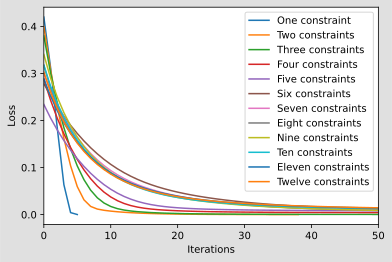

In [ ]:
plt.figure()
plt.plot(np.arange(0,j), loss, label = "One constraint")
plt.plot(np.arange(0,j1), loss1, label = "Two constraints" )
plt.plot(np.arange(0,j2), loss2, label = "Three constraints")
plt.plot(np.arange(0, j3), loss3, label = "Four constraints")
plt.plot(np.arange(0, j4), loss4, label = "Five constraints")
plt.plot(np.arange(0, j5), loss5, label = "Six constraints")
plt.plot(np.arange(0, j6), loss6, label = "Seven constraints")
plt.plot(np.arange(0, j7), loss7, label = "Eight constraints")
plt.plot(np.arange(0, j8), loss8, label = "Nine constraints")
plt.plot(np.arange(0, j9), loss9, label = "Ten constraints")
plt.plot(np.arange(0, j10), loss10, label = "Eleven constraints")
plt.plot(np.arange(0, j11), loss11, label = "Twelve constraints")



plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.xlim(0,50)
plt.show()

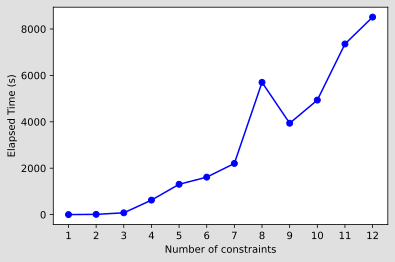

In [ ]:
x = np.arange(1,13)  # x-axis values
y = [tim, tim1, tim2, tim3, tim4, tim5, tim6, tim7, tim8, tim9, tim10, tim11]  # y-axis values

plt.plot(x, y, marker='o', linestyle='-', color='blue')  # Connect points with lines and show them as scatter points
plt.xlabel('Number of constraints')  # X-axis label
plt.ylabel('Elapsed Time (s)')  # Y-axis label
# plt.title('Elapsed Time vs. X')  # Plot title
plt.xticks(x)
plt.show()  # Display the plot


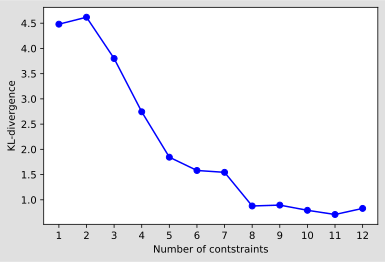

In [ ]:
x = np.arange(1,13)  # x-axis values
y = [kl, kl1, kl2, kl3, kl4, kl5, kl6, kl7, kl8, kl9, kl10, kl11]  # y-axis values

plt.plot(x, y, marker='o', linestyle='-', color='blue')  # Connect points with lines and show them as scatter points
# plt.xlabel('X')  # X-axis label
# plt.ylabel('Elapsed Time (seconds)')  # Y-axis label
# plt.title('Elapsed Time vs. X')  # Plot title
plt.xticks(x)
plt.xlabel("Number of contstraints")
plt.ylabel("KL-divergence")
plt.show()  # Display the plot